# Chorus Analytics

In [197]:
import plotly
import plotly.offline as pyo
import plotly.graph_objs as go

# Initialize plotly in offline mode
plotly.offline.init_notebook_mode(connected=True)


In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from emojis import emojis
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

In [199]:
data1 = pd.read_csv("../data/logs_05-23_19-11-48.csv")
data2 = pd.read_csv("../data/logs_05-23_19-12-15.csv")
data3 = pd.read_csv("../data/logs_05-23_19-12-35.csv")
data4 = pd.read_csv("../data/logs_05-23_19-13-23.csv")

## choose sample dataset

In [200]:
data = data2

In [201]:
data['time_label'] = pd.to_datetime(data.timestamp, unit = 'ms')
data.set_index('time_label', inplace=True)

In [202]:
category_counts = data['reaction'].astype('category').value_counts()
# Get the labels and counts for the pie chart
labels = category_counts.index.tolist()
counts = category_counts.values.tolist()

# Plots

## Distribution of Reaction

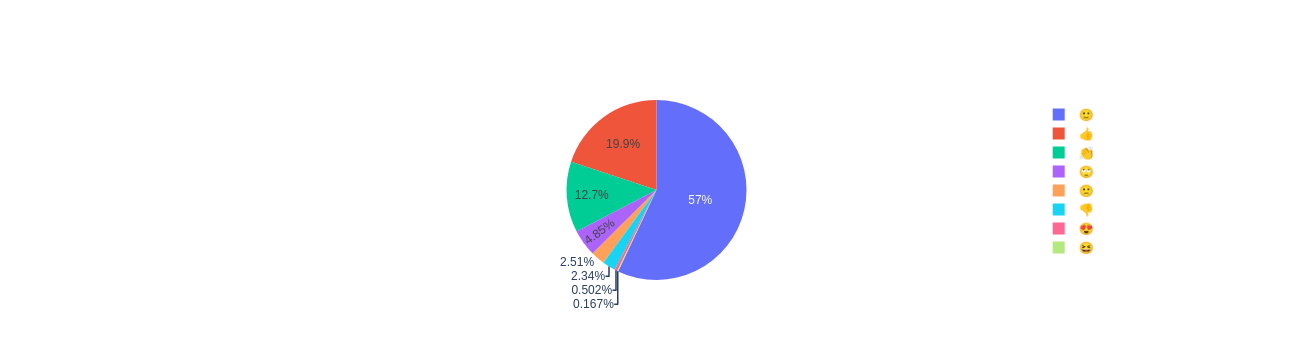

In [203]:
fig = go.Figure(data=[go.Pie(labels=labels, values=counts)])
fig.show()
fig.write_image("pie_chart.png")

# Distribution of Reaction numbers for all clients

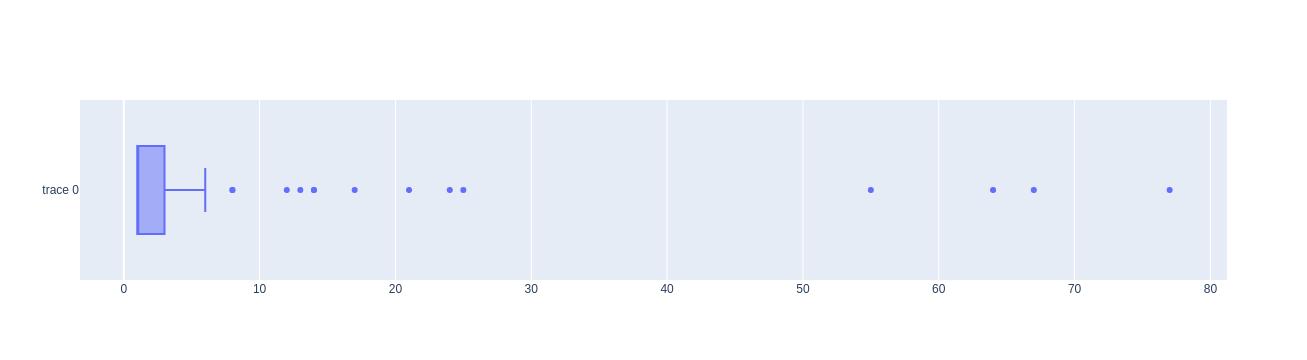

In [204]:
fig = go.Figure(data=[go.Box(x=data.userId.value_counts().values.tolist())])
fig.show()

# Change of the Number of Reactions over time

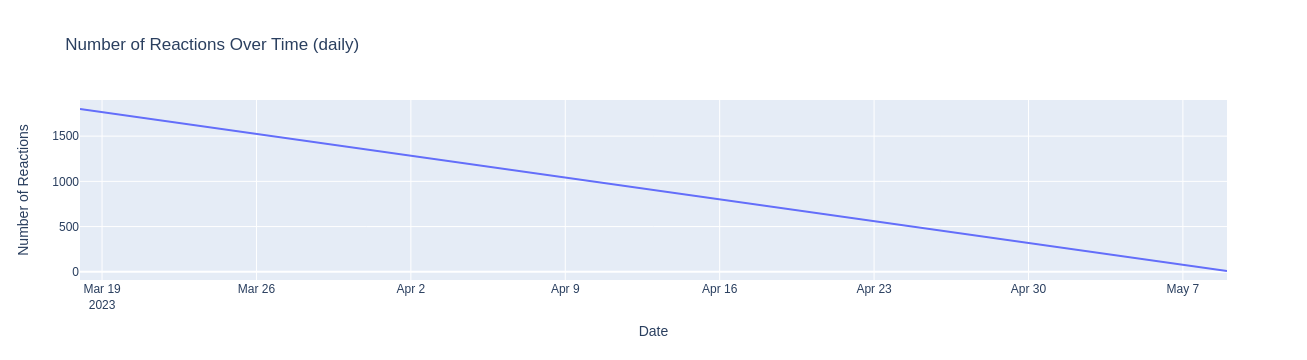

In [205]:
data = data3
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data_count = data.groupby(data['timestamp'].dt.date).count()

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_count.index, y=data_count['reaction'], mode='lines'))

fig.update_layout(title_text='Number of Reactions Over Time (daily)',
                  xaxis_title='Date',
                  yaxis_title='Number of Reactions')

fig.show()


# Box plot of Reaction Values by assigning a numeric value to the feeling of each of reaction

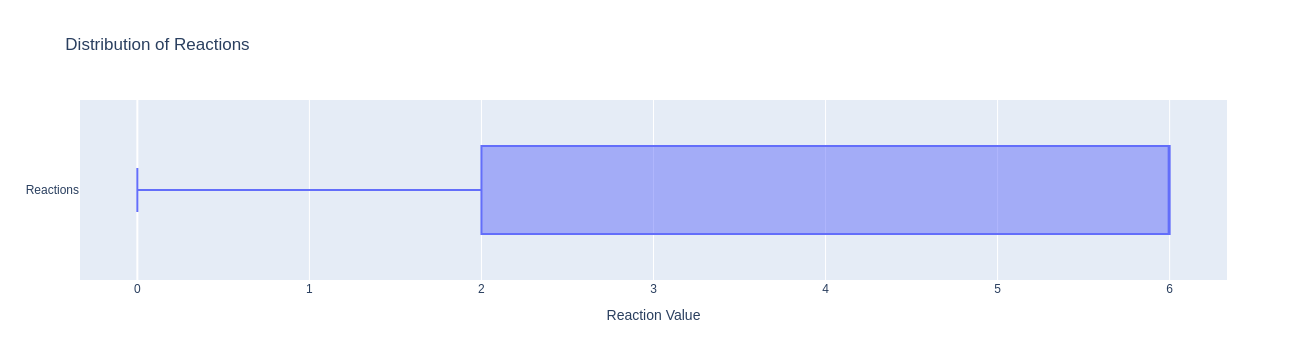

In [206]:
reaction_mapping = {
    '🙁': 1,
    '👎': 2,
    '🙄': 3,
    '🙂': 4,
    '😆': 5,
    '👍': 6,
    '👏': 7,
    '😍': 8,
}

data['reaction_value'] = data['reaction'].map(emoji_mapping).fillna(0)

fig = go.Figure()
fig.add_trace(go.Box(x=data['reaction_value'], name='Reactions', orientation='h'))
fig.update_layout(
    title='Distribution of Reactions',
    xaxis=dict(title='Reaction Value')
)
fig.show()

# Correlation of the feeling of reactions and how many times the client has pressed the button

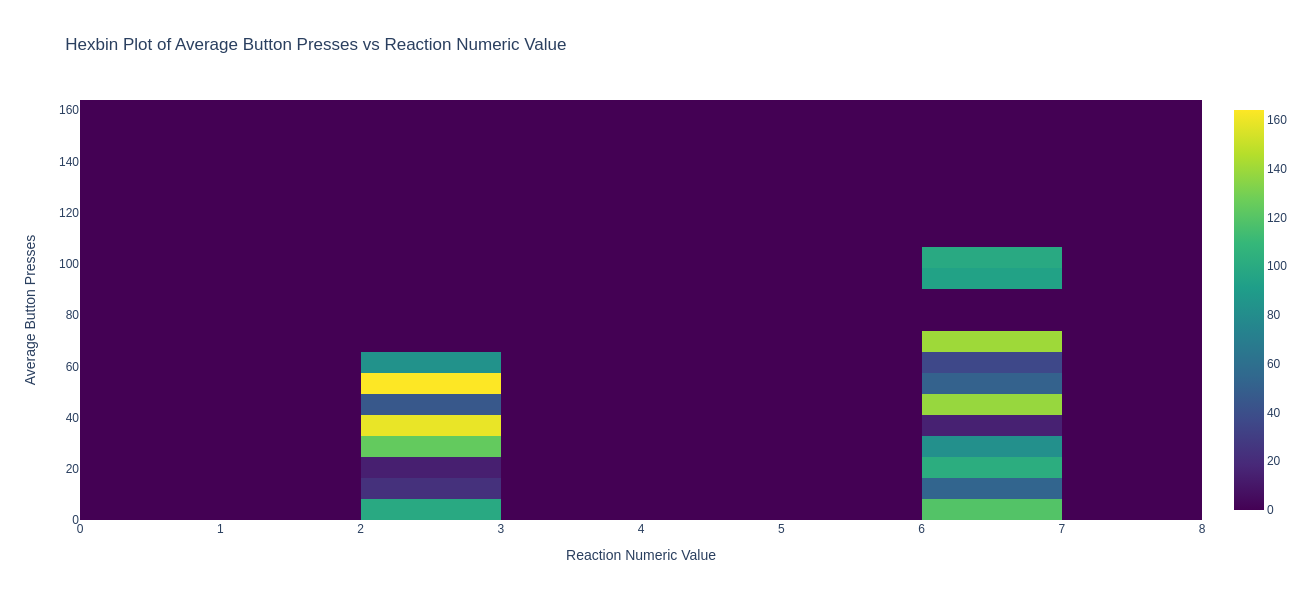

In [207]:
data['reaction_numeric'] = data['reaction'].map(reaction_mapping)

# Calculate the average number of presses per reaction for each user
average_presses = data.groupby(['userId', 'reaction_numeric']).size().groupby('userId').mean().reset_index(name='average_presses')

# Merge this information back into the dataframe
data = pd.merge(data, average_presses, how='left', on='userId')

# Create hexbin plot
fig = go.Figure(go.Histogram2d(
    x=data['reaction_numeric'],
    y=data['average_presses'],
    autobinx=False,
    xbins=dict(start=0, end=8, size=1),  # Adjust size to change the resolution of the hexbins
    autobiny=False,
    ybins=dict(start=0, end=data['average_presses'].max(), size=data['average_presses'].max()/20),  # Adjust size to change the resolution of the hexbins
    colorscale='Viridis'
))

fig.update_layout(
    title='Hexbin Plot of Average Button Presses vs Reaction Numeric Value',
    xaxis_title='Reaction Numeric Value',
    yaxis_title='Average Button Presses',
    autosize=False,
    width=600,
    height=600,
)

fig.show()


# Change of Reaction for a specific person

### specify the client by their id

In [212]:
user_id = 'ASWaWCYrTh3RpzUfABFP'

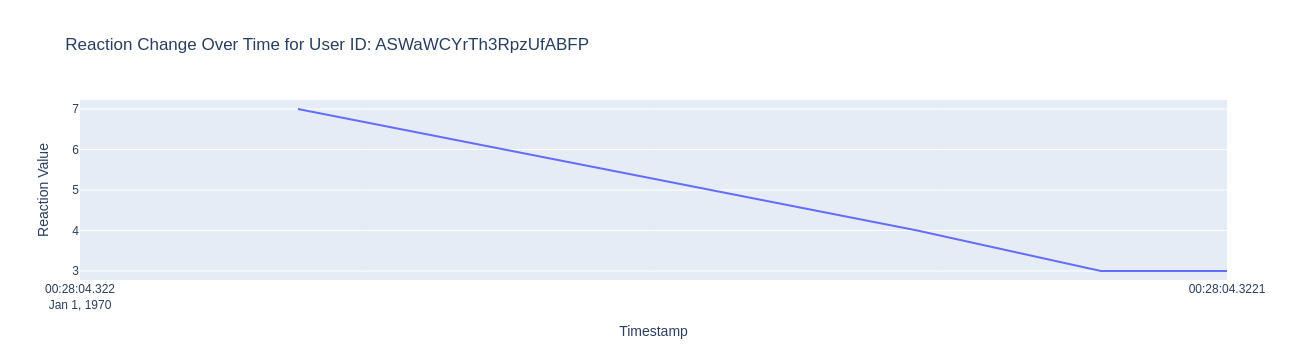

In [214]:
data = data2
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Filter the DataFrame for a specific user ID
user_data = data[data['userId'] == user_id]

# Apply the mapping function to the reaction column
user_data['reaction_value'] = user_data['reaction'].map(emoji_mapping).fillna(0)

# Plot the change in reaction over time using Plotly
fig = px.line(user_data, x='timestamp', y='reaction_value', title=f'Reaction Change Over Time for User ID: {user_id}')
fig.update_xaxes(title_text='Timestamp')
fig.update_yaxes(title_text='Reaction Value')
fig.show()

## Changes of number of Each Reactions over the time

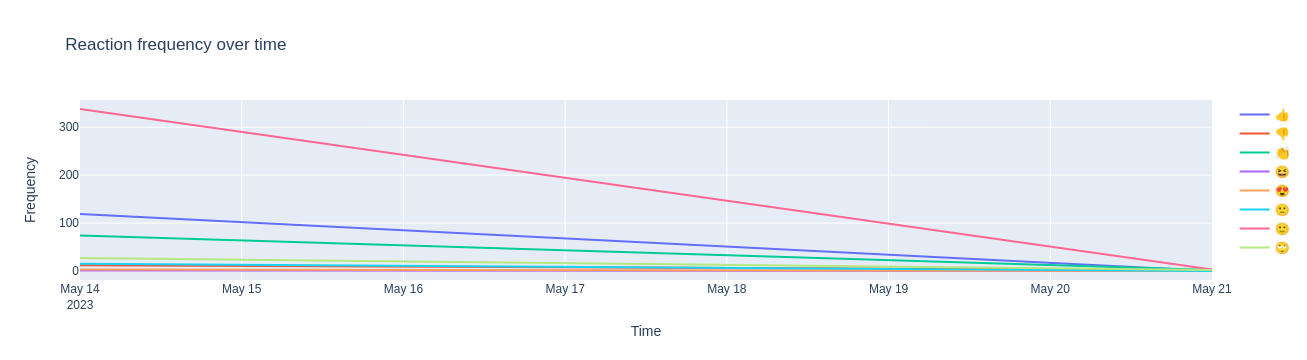

In [215]:
data.index = pd.to_datetime(data.index)

# resample the data into weekly bins and then calculate the value counts for each bin
weekly_counts = data.resample('W').reaction.value_counts()
# unstack the hierarchical index produced by value_counts
weekly_counts = weekly_counts.unstack(level=-1, fill_value=0)

fig = go.Figure()
# Loop through each unique reaction
for reaction in weekly_counts.columns:
    fig.add_trace(go.Scatter(x=weekly_counts.index, 
                             y=weekly_counts[reaction], 
                             mode='lines', 
                             name=reaction))
fig.update_layout(title='Reaction frequency over time',
                  xaxis_title='Time',
                  yaxis_title='Frequency')

fig.show()

# Distributions of Different Reactions in the hours of day

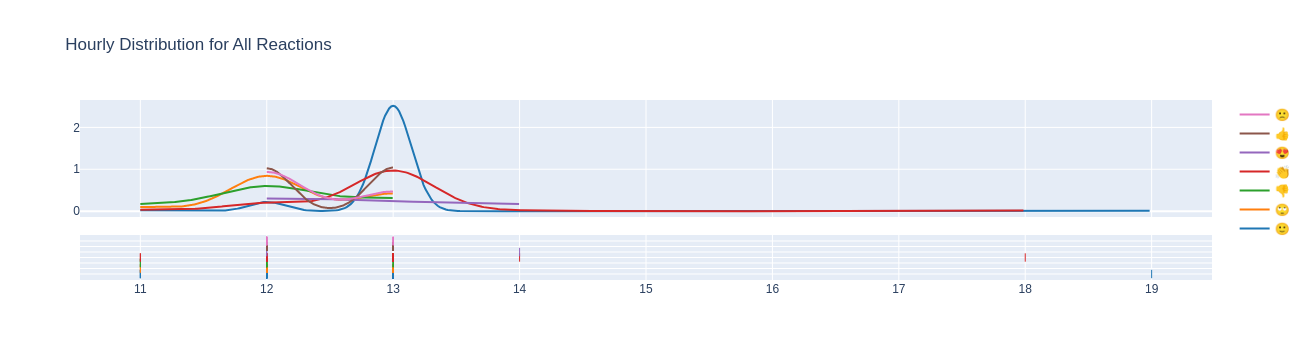

In [216]:
# Convert the index to datetime (if it's not already)
data.index = pd.to_datetime(data.index)

# Create an 'hour' column
data['hour'] = data.index.hour

hist_data = []
group_labels = []
# Get all unique reactions
unique_reactions = data['reaction'].unique()

# Loop through all unique reactions
for reaction in unique_reactions:
    # get the hours where the reaction occurred
    reaction_hours = data[data['reaction'] == reaction].hour

    # Only add to plot if there are at least two unique values
    if len(reaction_hours.unique()) > 1:
        hist_data.append(reaction_hours)
        group_labels.append(reaction)

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, curve_type='kde', show_hist=False,)
fig.update_layout(title_text='Hourly Distribution for All Reactions')
fig.show()